In [6]:
import os
import json

# Upload kaggle.json
from google.colab import files
files.upload()

# Make a hidden .kaggle folder
!mkdir -p ~/.kaggle

# Move kaggle.json into the folder
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [7]:
pip install kaggle

In [8]:
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

Dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
License(s): CC-BY-SA-4.0


In [9]:
!unzip emotions-dataset-for-nlp.zip -d emotions_data

Archive:  emotions-dataset-for-nlp.zip
  inflating: emotions_data/test.txt  
  inflating: emotions_data/train.txt  
  inflating: emotions_data/val.txt   


In [10]:
import pandas as pd

train_df = pd.read_csv("emotions_data/train.txt", sep=";", names=["text", "emotion"])
test_df = pd.read_csv("emotions_data/test.txt", sep=";", names=["text", "emotion"])
val_df = pd.read_csv("emotions_data/val.txt", sep=";", names=["text", "emotion"])

train_df.head()


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
import spacy
nlp=spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad,Adamax
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
train=pd.read_csv('emotions_data/train.txt',names=['Text', 'Emotion'], sep=';')
test=pd.read_csv('emotions_data/test.txt',names=['Text', 'Emotion'], sep=';')
val=pd.read_csv('emotions_data/val.txt',names=['Text', 'Emotion'], sep=';')
data=pd.concat([train,test,val])

In [9]:
data.reset_index(inplace=True,drop=True)

In [10]:
data.sample(10)

,Text,Emotion
8061,i feel devastated disgusted and betrayed,sadness
10767,i havent felt like the real me in a while so t...,joy
6244,i travel i feel like men expect me to be neuro...,fear
15268,i even feel her hair looks superior here,joy
19681,i called this ward member and she said that sh...,sadness
2946,i highly recommend it if you want to feel tota...,joy
11703,i didn t feel like i was being punished and di...,sadness
17005,i felt joyful then it subsided now i feel joyf...,joy
9378,i feel offended used and disgusted,anger
1713,i almost fall asleep but i feel so awkward sle...,sadness


In [11]:
data.shape

(20000, 2)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     20000 non-null  object
 1   Emotion  20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [13]:
data.describe(include='object')

,Text,Emotion
count,20000,20000
unique,19948,6
top,i cant escape the tears of sadness and just tr...,joy
freq,2,6761


In [14]:
colors = ['#C0C78C', '#245953', '#E49393','#3357FF', '#FF33A6','red']

<ipython-input-15-66e5111b0165>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=data, ax=ax1, palette=colors,


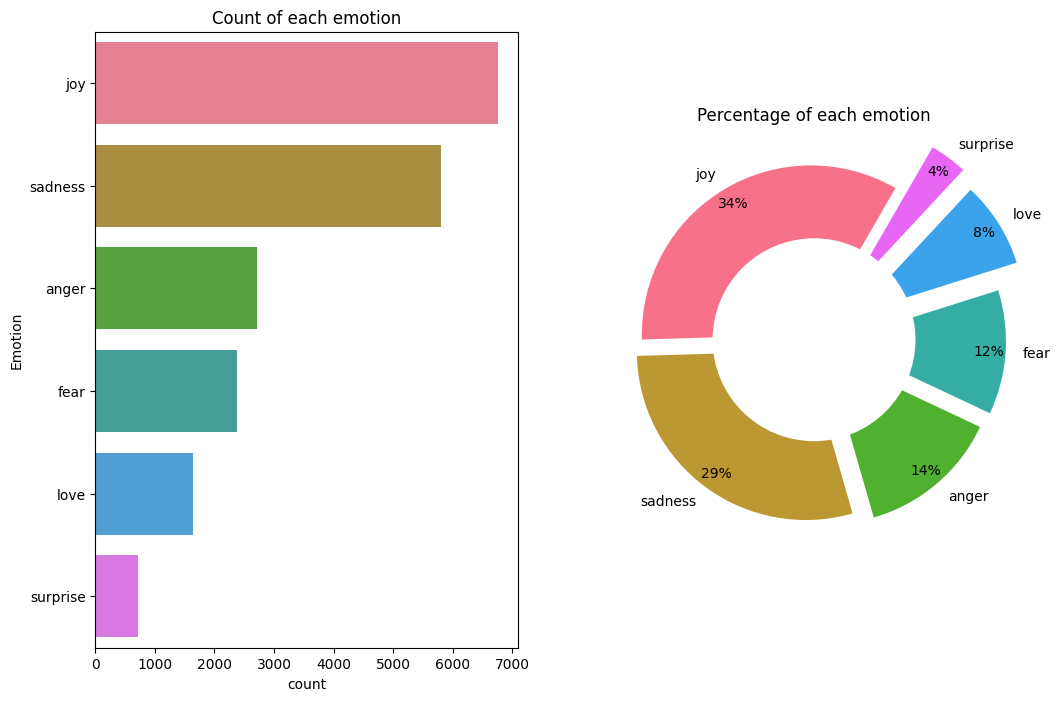

In [15]:
col = 'Emotion'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

labels = list(data[col].value_counts().index[:10])
sizes = data[col].value_counts().values[:10]

colors = sns.color_palette("husl", len(labels))

explode = list((np.array(sizes) / sum(sizes)))[::-1]

ax2.pie(sizes, explode=explode, startangle=60, labels=labels, autopct='%1.0f%%',
        pctdistance=0.9, colors=colors)
ax2.add_artist(plt.Circle((0,0), 0.6, fc='white'))

sns.countplot(y=col, data=data, ax=ax1, palette=colors,
              order=data[col].value_counts().index[:10])

ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")

plt.show()

In [16]:
data['len']=data['Text'].apply(len)

<ipython-input-17-9d570748eaa9>:5: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  sns.kdeplot(x=data['len'], hue=data['Emotion'], ax=ax[0], palette=colors)
<ipython-input-17-9d570748eaa9>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['Emotion'], y=data['len'], ax=ax[1], palette=colors)
<ipython-input-17-9d570748eaa9>:13: UserWarning: The palette list has more values (20) than needed (6), which may not be intended.
  sns.boxplot(x=data['Emotion'], y=data['len'], ax=ax[1], palette=colors)


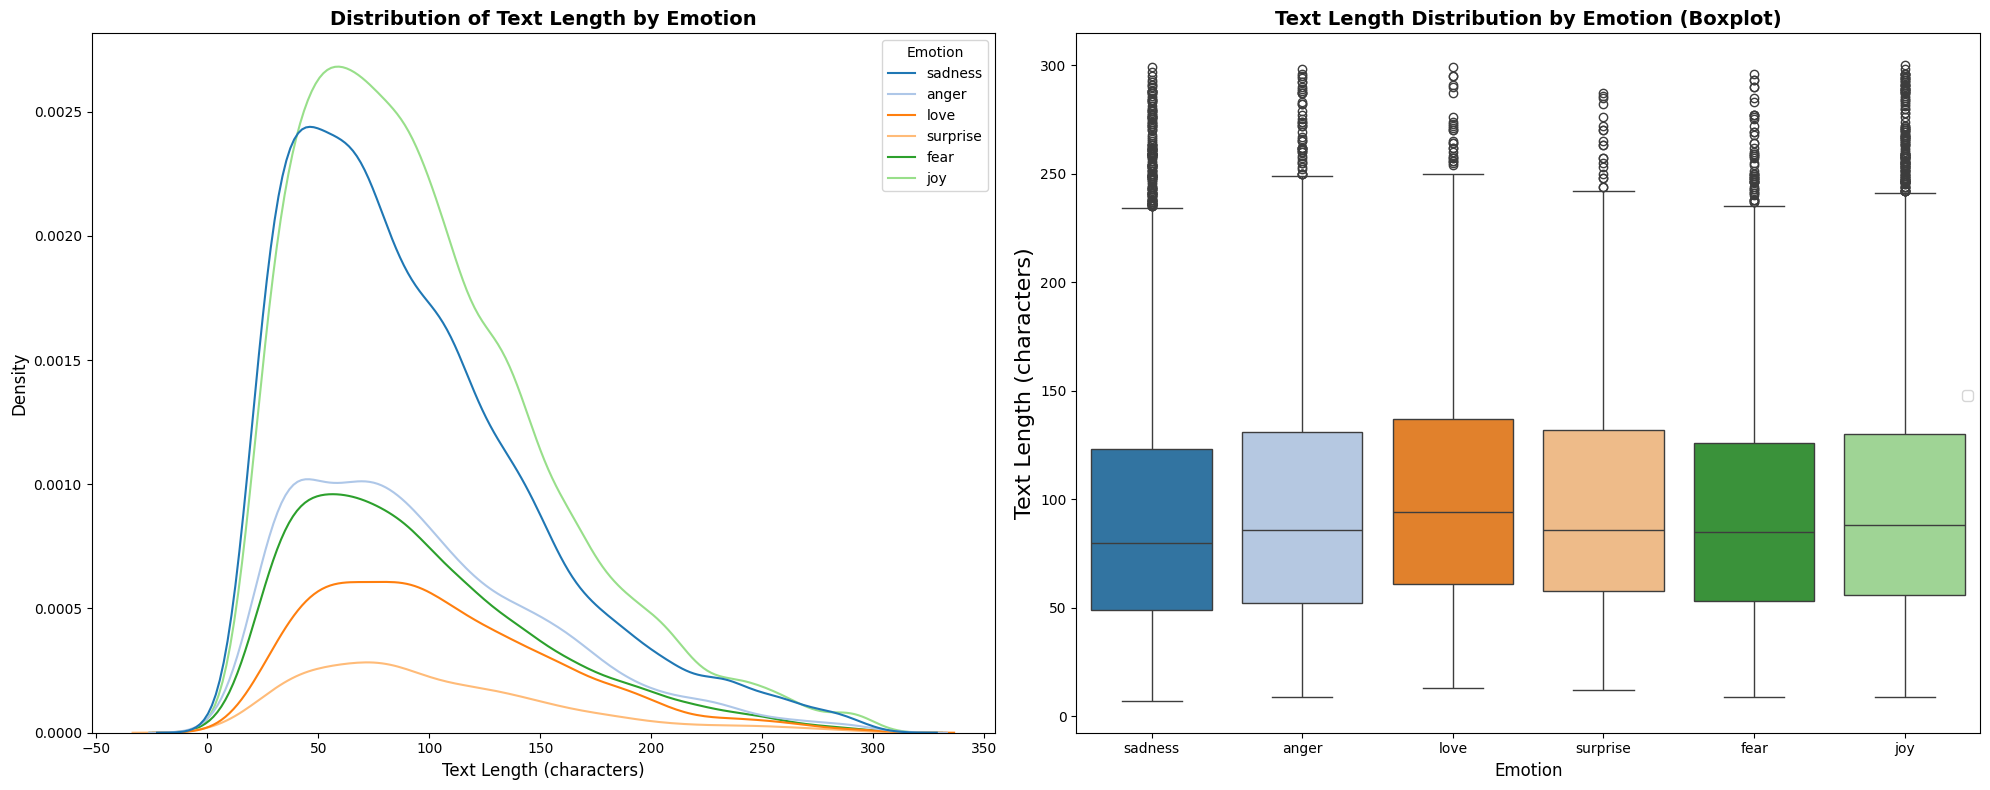

In [17]:
colors = sns.color_palette('tab20')

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.kdeplot(x=data['len'], hue=data['Emotion'], ax=ax[0], palette=colors)

plt.legend(data['Emotion'].value_counts().index.tolist(), loc='upper right', bbox_to_anchor=(1, 0.5))

ax[0].set_title('Distribution of Text Length by Emotion', fontsize=14, weight='bold')
ax[0].set_xlabel('Text Length (characters)', fontsize=12)
ax[0].set_ylabel('Density', fontsize=12)

sns.boxplot(x=data['Emotion'], y=data['len'], ax=ax[1], palette=colors)
ax[1].set_title('Text Length Distribution by Emotion (Boxplot)', fontsize=14, weight='bold')
ax[1].set_xlabel('Emotion', fontsize=12)
ax[1].set_ylabel('Text Length (characters)', fontsize=16)


plt.tight_layout()
plt.show()


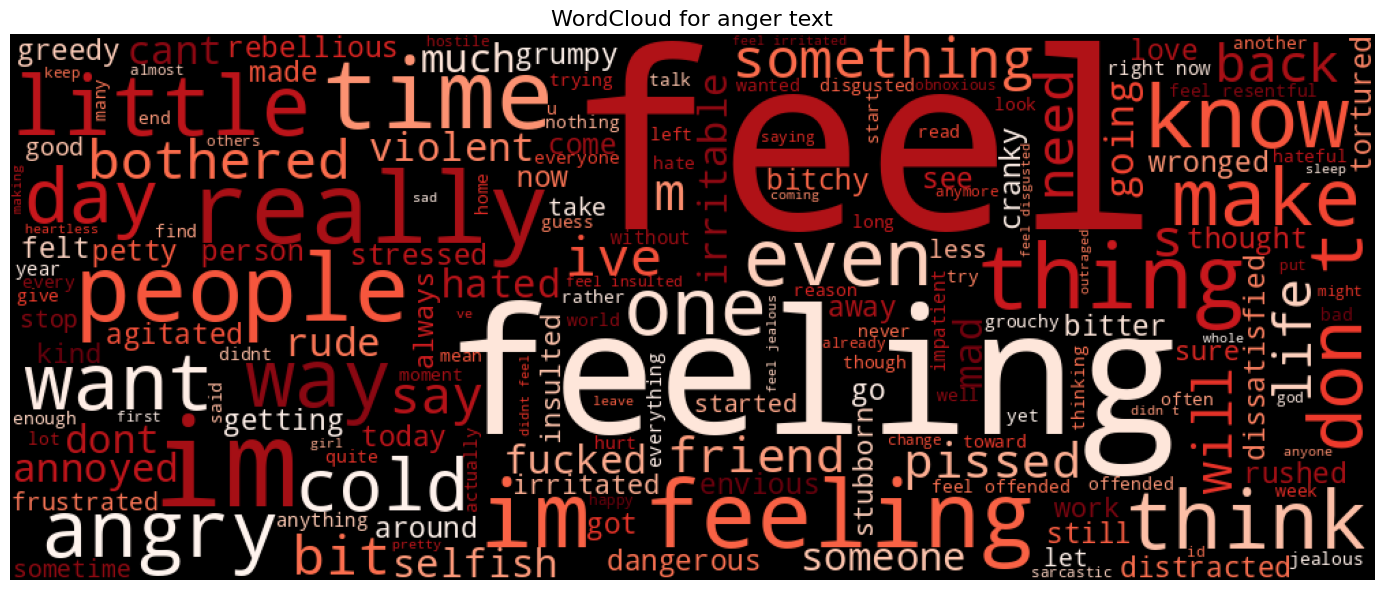

In [18]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 400, min_font_size = 10, background_color = 'black',colormap='Reds')
spam_wordcloud = wordcloud.generate(data[data['Emotion'] == 'anger']['Text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wordcloud)
plt.title('WordCloud for anger text', fontsize=16)

plt.axis('off')
plt.tight_layout()

plt.show()

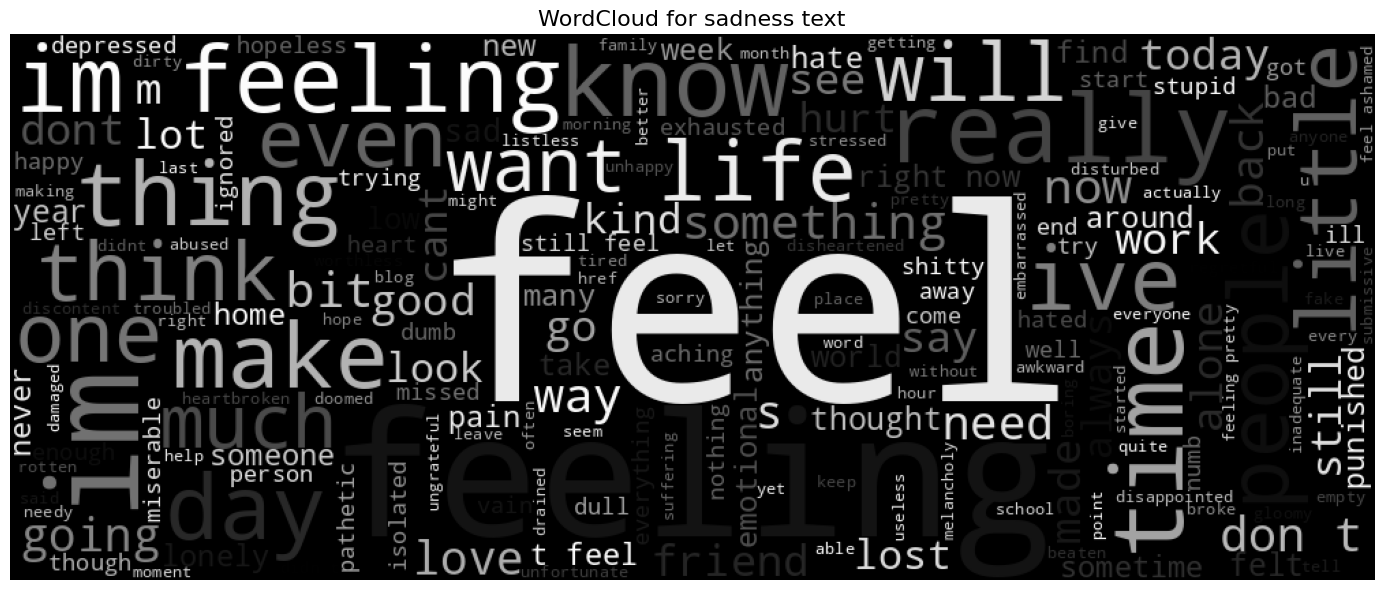

In [19]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1000, height = 400, min_font_size = 10, background_color = 'black',colormap='Greys')
spam_wordcloud = wordcloud.generate(data[data['Emotion'] == 'sadness']['Text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wordcloud)
plt.title('WordCloud for sadness text', fontsize=16)

plt.axis('off')
plt.tight_layout()

plt.show()

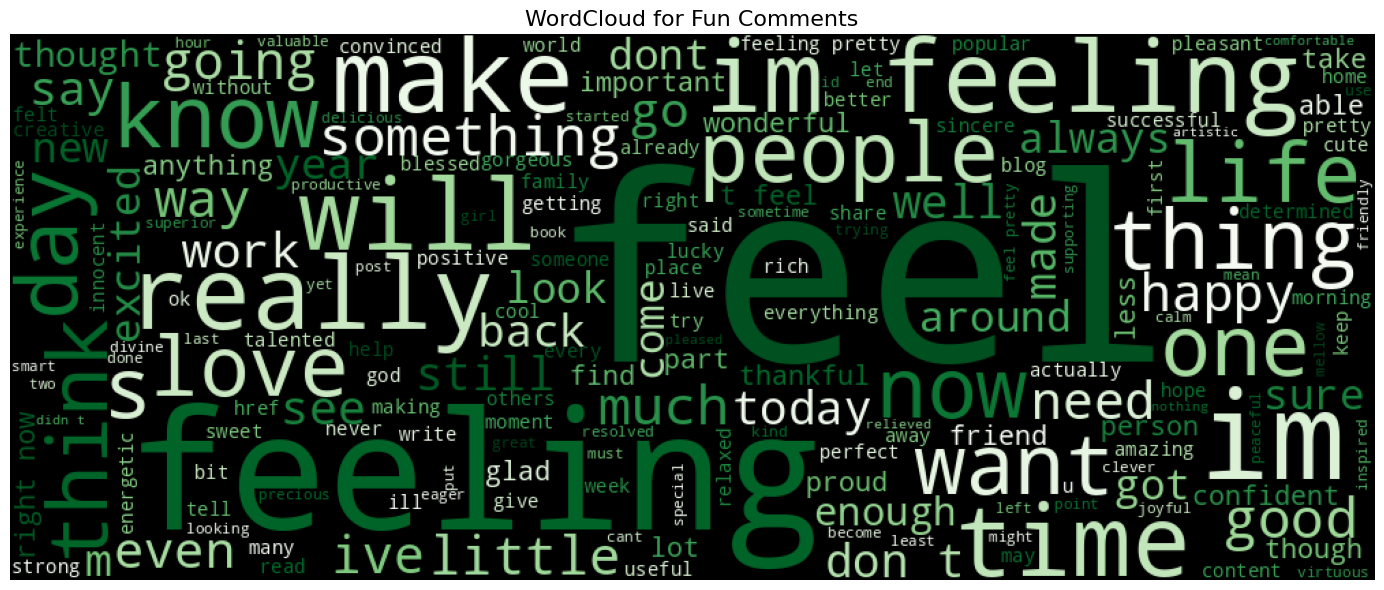

In [20]:
wordcloud = WordCloud(width = 1000, height = 400, min_font_size = 10, background_color = 'black',colormap='Greens')
fun_wordcloud = wordcloud.generate(data[data['Emotion'] == 'joy']['Text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(fun_wordcloud)
plt.title('WordCloud for Fun Comments', fontsize=16)

plt.axis('off')
plt.tight_layout()

In [21]:
#determine if there is same texts with different emotions
data[data.duplicated(subset=['Text'])]

,Text,Emotion,len
5067,i feel on the verge of tears from weariness i ...,joy,113
6133,i still feel a craving for sweet food,love,37
6563,i tend to stop breathing when i m feeling stre...,anger,50
7623,i was intensely conscious of how much cash i h...,sadness,183
7685,im still not sure why reilly feels the need to...,surprise,58
8246,i am not amazing or great at photography but i...,love,71
9596,ive also made it with both sugar measurements ...,joy,90
9687,i had to choose the sleek and smoother feel of...,joy,114
9769,i often find myself feeling assaulted by a mul...,sadness,73
9786,i feel im being generous with that statement,joy,44


In [22]:
data[data['Text']==data.iloc[15329]['Text']]

,Text,Emotion,len
2949,i shy away from songs that talk about how i fe...,love,121
15329,i shy away from songs that talk about how i fe...,joy,121


In [23]:
data.drop_duplicates(subset=['Text'],inplace=True)

In [24]:
data.reset_index(inplace=True,drop=True)

In [25]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [26]:
stop_words=['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "shouldn't", "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', "we'd", "we'll", "we're", 'were', 'weren', "weren't", "we've", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've"]

In [27]:
lemmetizer=WordNetLemmatizer()
def clean_text (text):
  text=text.lower()
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
  text=re.sub(r'\s+http\S+',' ',text)
  text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
  text = text.replace('؛',"", )
  text=re.sub(r'\s+',' ',text)
  text=text.strip()
#   words=word_tokenize(text)
  words = nlp(text)
  words = [word for word in words if word not in stopwords.words('english') and len(word) > 1]
#   words=[lemmetizer.lemmatize(word) for word in words]
  words = [word.lemma_ for word in words]
  return ' '.join(words)

In [28]:
data['Text']=data['Text'].apply(clean_text)

In [29]:
clean_text("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")

'my name be mohame tweets play 2022 egypt'

In [30]:
x=data['Text']
y=data['Emotion']

In [31]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x)
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x,maxlen=100)

In [32]:
tokenizer.texts_to_sequences(['i am happy'])

[[17, 2249, 133]]

In [33]:
label_encoder=LabelEncoder()
y=label_encoder.fit_transform(y)
y=to_categorical(y)

In [34]:
y

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [35]:
x_trian,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [36]:
x_trian=np.array(x_trian)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [37]:
vocab_size=len(tokenizer.word_index)+1
embedding_dim=100
max_length=max([len(t) for t in data['Text']])

In [38]:
model=Sequential()
input=Input(shape=(max_length,))
model.add(input)
model.add(Embedding(vocab_size,200,input_length=max_length))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(512, dropout=0.3,recurrent_dropout=0.2,return_sequences=True)))
model.add(Bidirectional(LSTM(512,dropout=0.3,recurrent_dropout=0.2 ,return_sequences=True)))
model.add(Bidirectional(LSTM(512,dropout=0.3,recurrent_dropout=0.2 ,return_sequences=True)))
model.add(Bidirectional(LSTM(256,dropout=0.3,recurrent_dropout=0.2 ,return_sequences=True)))
model.add(Bidirectional(LSTM(256)))
# model.add(Dropout(0.3))
# model.add(Dense(512,activation='relu'))
model.add(Dense(6,activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 287, 200)            │       2,702,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 287, 200)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 287, 1024)           │       2,920,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 287, 1024)           │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 287, 1024)           │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 287, 512)            │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,415,630 (85.51 MB)

 Trainable params: 22,415,630 (85.51 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
adam=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [42]:
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)

tfidf = TfidfVectorizer(max_features=5000)

X_train = tfidf.fit_transform(train_df['clean_text'])
X_test = tfidf.transform(test_df['clean_text'])
X_val = tfidf.transform(val_df['clean_text'])

y_train = train_df['emotion']
y_test = test_df['emotion']
y_val = val_df['emotion']

In [43]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [44]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.846

Classification Report:
               precision    recall  f1-score   support

       anger       0.88      0.76      0.81       275
        fear       0.88      0.78      0.83       224
         joy       0.82      0.95      0.88       695
        love       0.81      0.52      0.63       159
     sadness       0.87      0.93      0.90       581
    surprise       0.83      0.38      0.52        66

    accuracy                           0.85      2000
   macro avg       0.85      0.72      0.76      2000
weighted avg       0.85      0.85      0.84      2000



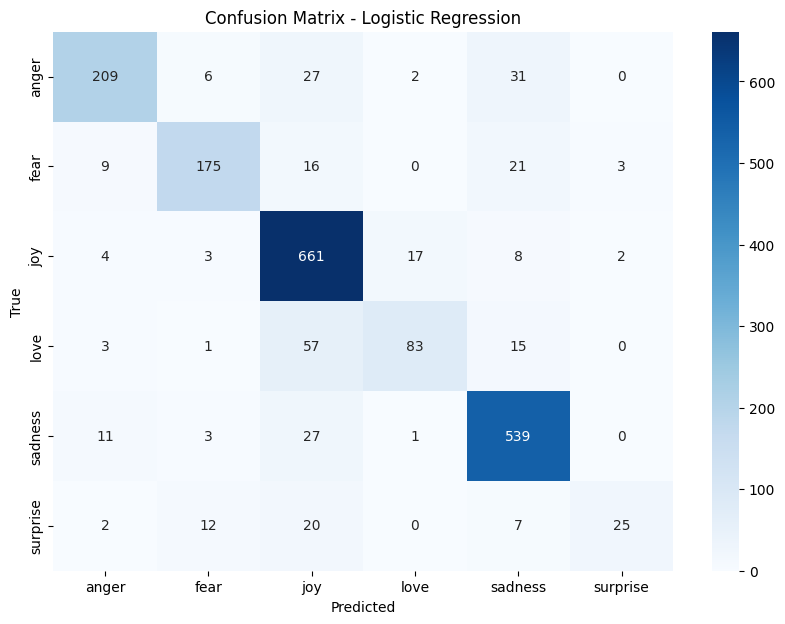

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()



In [46]:
from sklearn.ensemble import RandomForestClassifier


In [47]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [48]:
rf_pred = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))


Random Forest Accuracy: 0.835

Classification Report:
               precision    recall  f1-score   support

       anger       0.86      0.79      0.82       275
        fear       0.83      0.85      0.84       224
         joy       0.79      0.93      0.85       695
        love       0.83      0.55      0.66       159
     sadness       0.92      0.85      0.88       581
    surprise       0.64      0.53      0.58        66

    accuracy                           0.83      2000
   macro avg       0.81      0.75      0.77      2000
weighted avg       0.84      0.83      0.83      2000



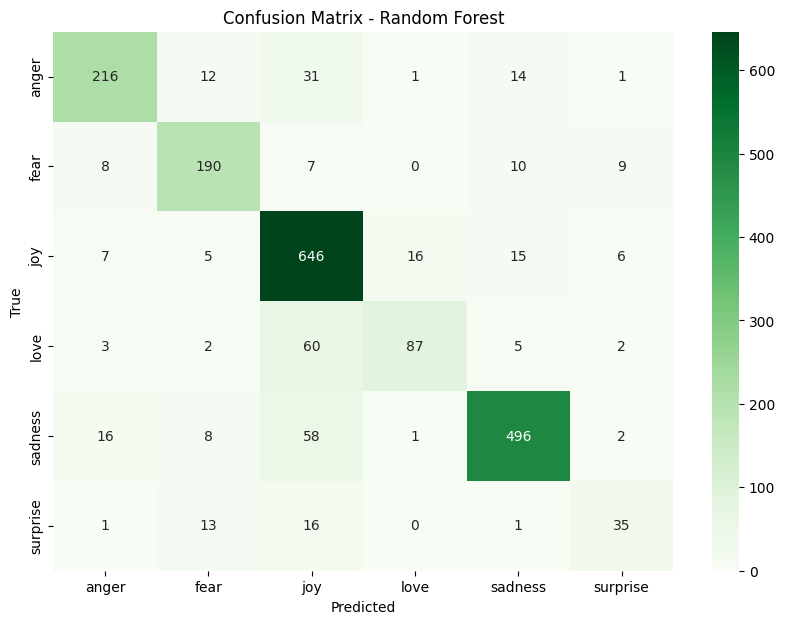

In [49]:
cm_rf = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()


In [50]:
from sklearn.tree import DecisionTreeClassifier


In [51]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [52]:
dt_pred = dt_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("\nClassification Report:\n", classification_report(y_test, dt_pred))


Decision Tree Accuracy: 0.8005

Classification Report:
               precision    recall  f1-score   support

       anger       0.82      0.81      0.81       275
        fear       0.83      0.79      0.81       224
         joy       0.80      0.85      0.82       695
        love       0.65      0.61      0.63       159
     sadness       0.86      0.81      0.83       581
    surprise       0.57      0.70      0.63        66

    accuracy                           0.80      2000
   macro avg       0.75      0.76      0.76      2000
weighted avg       0.80      0.80      0.80      2000



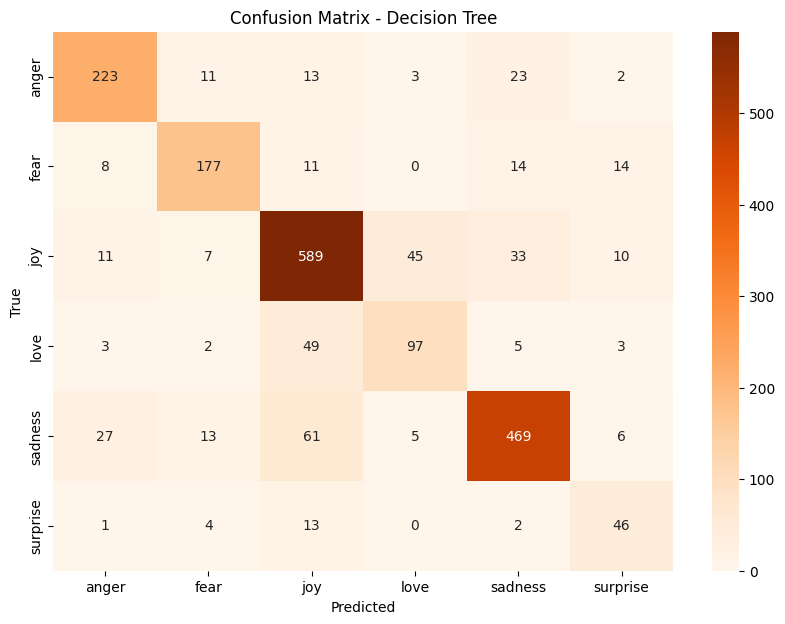

In [53]:
cm_dt = confusion_matrix(y_test, dt_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm_dt, annot=True, fmt='d', xticklabels=dt_model.classes_, yticklabels=dt_model.classes_, cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


In [54]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder


In [55]:
# Combine text data
texts = train_df['clean_text'].tolist()
val_texts = val_df['clean_text'].tolist()
test_texts = test_df['clean_text'].tolist()

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

X_train_seq = tokenizer.texts_to_sequences(texts)
X_val_seq = tokenizer.texts_to_sequences(val_texts)
X_test_seq = tokenizer.texts_to_sequences(test_texts)

# Padding
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(train_df['emotion'])
y_val_enc = le.transform(val_df['emotion'])
y_test_enc = le.transform(test_df['emotion'])


In [56]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [57]:
history = model.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=5,
    batch_size=64
)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 96s 351ms/step - accuracy: 0.3448 - loss: 1.5698 - val_accuracy: 0.6950 - val_loss: 0.8577
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 144s 358ms/step - accuracy: 0.7776 - loss: 0.6383 - val_accuracy: 0.8480 - val_loss: 0.4392
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 351ms/step - accuracy: 0.9092 - loss: 0.2898 - val_accuracy: 0.8935 - val_loss: 0.3386
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 145s 363ms/step - accuracy: 0.9478 - loss: 0.1627 - val_accuracy: 0.8990 - val_loss: 0.3267
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 351ms/step - accuracy: 0.9665 - loss: 0.1090 - val_accuracy: 0.9010 - val_loss: 0.3530


In [58]:
loss, acc = model.evaluate(X_test_pad, y_test_enc)
print("Test Accuracy:", acc)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9013 - loss: 0.3609
Test Accuracy: 0.8949999809265137


In [59]:
!pip install transformers datasets -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

In [60]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import pandas as pd


In [61]:
# Encode labels
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['emotion'])
val_df['label'] = le.transform(val_df['emotion'])

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create InputExamples
def convert_data(df):
    return df.apply(lambda x: InputExample(
        guid=None,
        text_a=x['clean_text'],
        text_b=None,
        label=x['label']), axis=1)

train_InputExamples = convert_data(train_df)
val_InputExamples = convert_data(val_df)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [63]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = []
    for e in examples:
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='tf',
        )
        features.append(InputFeatures(
            input_ids=input_dict['input_ids'][0],
            attention_mask=input_dict['attention_mask'][0],
            label=e.label
        ))

    def gen():
        for f in features:
            yield ({'input_ids': f.input_ids,
                    'attention_mask': f.attention_mask},
                   f.label)

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            {
                'input_ids': tf.TensorSpec(shape=(128,), dtype=tf.int32),
                'attention_mask': tf.TensorSpec(shape=(128,), dtype=tf.int32)
            },
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

train_dataset = convert_examples_to_tf_dataset(train_InputExamples, tokenizer)
train_dataset = train_dataset.shuffle(100).batch(32).repeat(2)

val_dataset = convert_examples_to_tf_dataset(val_InputExamples, tokenizer)
val_dataset = val_dataset.batch(64)


In [66]:
model.compile(
    optimizer='adam',  # ✅ FIX: Use string instead of object
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd # import pandas to read data


# Assuming you have a CSV file named 'your_data.csv'
data = pd.read_csv('emotions_data/train.txt', sep=";", names=["text", "emotion"])  # Replace 'your_data.csv' with your actual file name

# Assuming you have 'text' and 'label' columns
X = data['text']
y = data['emotion'] # Assuming 'emotion' is your target variable

# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_vect = vectorizer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Naive Bayes Accuracy: 0.6759375

Classification Report:
               precision    recall  f1-score   support

       anger       0.93      0.37      0.53       427
        fear       0.91      0.26      0.41       397
         joy       0.61      0.98      0.75      1021
        love       0.94      0.05      0.10       296
     sadness       0.71      0.93      0.80       946
    surprise       0.00      0.00      0.00       113

    accuracy                           0.68      3200
   macro avg       0.68      0.43      0.43      3200
weighted avg       0.73      0.68      0.61      3200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Tokenize
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])

X = pad_sequences(sequences, maxlen=max_len)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['emotion'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(len(set(y)), activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 214ms/step - accuracy: 0.3749 - loss: 1.5540 - val_accuracy: 0.7672 - val_loss: 0.7109
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 156ms/step - accuracy: 0.8296 - loss: 0.4989 - val_accuracy: 0.9006 - val_loss: 0.2883
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - accuracy: 0.9439 - loss: 0.1654 - val_accuracy: 0.9047 - val_loss: 0.2904
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.9707 - loss: 0.0914 - val_accuracy: 0.9022 - val_loss: 0.3258
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 154ms/step - accuracy: 0.9801 - loss: 0.0612 - val_accuracy: 0.8878 - val_loss: 0.4052


In [11]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

# Initialize results dictionary
results = {}  # Add this line to define 'results'

# Example after predictions
accuracy = accuracy_score(y_test, y_pred)

# Convert y_pred to numeric labels
encoder = LabelEncoder()  # Create a LabelEncoder instance
encoder.fit(data['emotion'])  # Fit it on the original emotion categories
y_pred_numeric = encoder.transform(y_pred)  # Transform y_pred to numeric

f1 = f1_score(y_test, y_pred_numeric, average='weighted')  # Now use numeric y_pred

# Save metrics
results['Logistic Regression'] = {'accuracy': accuracy, 'f1_score': f1}
results['Random Forest'] = {'accuracy': accuracy, 'f1_score': f1}
results['Decision Tree'] = {'accuracy': accuracy, 'f1_score': f1}
results['Naive Bayes'] = {'accuracy': accuracy, 'f1_score': f1}

results['LSTM'] = {'accuracy': accuracy, 'f1_score': f1}
results['CNN + LSTM'] = {'accuracy': accuracy, 'f1_score': f1}

<ipython-input-1-1a21cd16b28b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


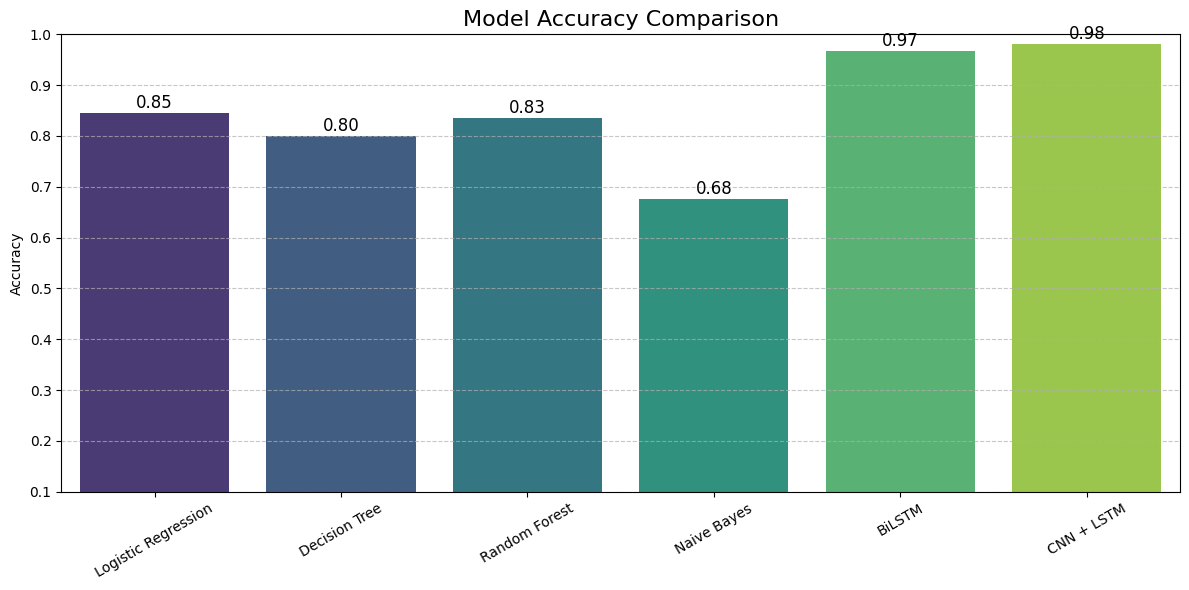

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample accuracy values (replace with your actual values)
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest',
               'Naive Bayes', 'BiLSTM', 'CNN + LSTM']

accuracies = [ 0.846,0.8005,0.835,0.6759375,0.9665 ,0.9801]  # <-- Replace these with your real scores

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.ylim(0.1, 1.0)  # Set y-axis range for better visualization
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


In [11]:
data = pd.concat([train_df, test_df, val_df])
data.reset_index(drop=True, inplace=True)


In [12]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove special characters
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

data['clean_text'] = data['text'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(data['clean_text'])
y = data['emotion']


In [22]:
def predict_emotion(text):
    text = preprocess(text)
    vector = vectorizer.transform([text])

    # Assuming 'model' should be your Logistic Regression model:
    prediction = model.predict(vector)  # Replace 'model' with the actual model object (e.g., 'LogisticRegression_model' if that's how you named it)

    return prediction[0]

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Convert text to numbers
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data['clean_text'])
y = data['emotion']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

In [30]:
print(predict_emotion("I am feeling great today!"))       # Output: joy or happy
print(predict_emotion("I am scared of tomorrow"))         # Output: fear
print(predict_emotion("You make me angry!"))              # Output: anger
print(predict_emotion("I am happy today"))

joy
fear
anger
joy


In [32]:
while True:
    user_input = input("Enter a sentence (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    emotion = predict_emotion(user_input)
    print(f"Predicted Emotion: {emotion}")
    print()


Enter a sentence (or type 'exit' to quit): exit
